# N.B.

After this notebook, we will switch back to Julia language.
The reasons are threefold:

* Julia provides a decent performance boost for free;
* Julia is the main language at LakeTide, technical support has neither distance nor latency;
* Julia has better support for OpenStreetMap, which is needed for future traffic simulation.

Switching from Julia to Python was not a bad idea per se;
Python plus Networkx worked quite well in the last two weeks as
the tool set to conduct the proof of concepts; currently, new
needs demand new set of tools.

# Heads-Up

In this notebook, we scale up the graph to 1000 nodes;
this makes the size of samples around one billion, which
makes it impossible to be generated and further augmented.

The way to cope with that is to randomly sample pairs of nodes
and generate training data from them. Idealy, the training size
before augmentation is around one millon.

The meaning of this stocastic manner is twofold.
* it reduced the complexity of training set generation massively
* this is a decent test to see if the model is truly able to generalize

# Problems

The algorithm does not seem to work well with a graph
of 1000 nodes, which is somehow disappointing.

Possible reasons are the following:

* The model is not powerful enough to learn the graph;
* The stochastic sampling of training data does not show the model the big picture, i.e.,
the model gets confused by the edges it has never seen before;

* The training sample should allow the model the take steps back, i.e., for each sample
path, the parent nodes should be included;

However, after deeper analysis, we tend to believe that it is certain properties of 
the graph that make the current model much harder to be trained and to infer. ("./Mar_19/")

# Make it "smarter" TODO

* Detect dead loop;
* Include the parent nodes (**tests show that this makes the model harder to be trained and less "intelligent"**)
* Randomize the input vectors duing inference

In [44]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score
from utils import plot_g

In [45]:
NUM_NODE = 100
WEIGHT_MIN = .5
WEIGHT_MAX = 1.

In [46]:
def calc_euclidean_dist(G, tmp_node, node):
    
    p_1 = np.array([G.nodes[tmp_node]['x'], G.nodes[tmp_node]['y']])
    p_2 = np.array([G.nodes[node]['x'], G.nodes[node]['y']])
    return np.sqrt(np.sum((p_1 - p_2)**2))

def generate_low_degree_g(num_nodes=100, min_out_degree=2, max_out_degree=4, weight_min=WEIGHT_MIN, weight_max=WEIGHT_MAX):
    
    G = nx.Graph()
    
    grid_size = 20000
    euclidean_coords = np.linspace(0.0, 1.0, num=grid_size, endpoint=False)
    coords_indices = list(range(grid_size))
    
    random.shuffle(coords_indices)
    x_coords = euclidean_coords[coords_indices][:num_nodes]
#     print(x_coords)
    random.shuffle(coords_indices)
    y_coords = euclidean_coords[coords_indices][:num_nodes]
#     print(y_coords)
    
    # Add coordinates to nodes
    for node, coord in enumerate(zip(x_coords, y_coords)):
#         print(node, coord[0], coord[1])
        G.add_node(node, x=coord[0], y=coord[1])
    
    for node in G.nodes:
        
        tmp_nodes = list(G.nodes)
        tmp_nodes.remove(node)
        node_dist = map(lambda tmp_node: (tmp_node, calc_euclidean_dist(G, tmp_node, node)), tmp_nodes)
        node_dist = sorted(node_dist, key=lambda d:d[1])
        
        num_of_neighbors = random.randint(min_out_degree, max_out_degree)
#         print(node, out_neighbors)
        
#         G.add_edges_from(map(lambda d:(node, d), out_neighbors))
        
        for tmp_node in node_dist:

            if G.degree(tmp_node[0]) >= max_out_degree \
                or G.degree(node) >= num_of_neighbors:
                # This node has maximum number of neighbors already
                continue
            
            weight = random.uniform(weight_min, weight_max)
            geo_dist = calc_euclidean_dist(G, tmp_node[0], node)
            
            G.add_edge(node, tmp_node[0], weight=weight * geo_dist)
    
    # Add centrality to edges
    edge_centrality = nx.edge_betweenness_centrality(G, \
                                                     k=G.number_of_nodes(), \
                                                     weight='weight')
    assert len(edge_centrality) == G.number_of_edges()
    
    for edge_data in G.edges.data():
        edge_data[2]['centrality'] = edge_centrality[(edge_data[0], edge_data[1])]
        
    return G

In [47]:
G = nx.read_gpickle("./Mar_19/graph.pickle")
max_degree = max(G.degree, key=lambda d: d[1])[1]
min_degree = min(G.degree, key=lambda d: d[1])[1]
print(max_degree)
print(min_degree)
print(G.number_of_nodes())
print(G.number_of_edges())

4
2
1000
1759


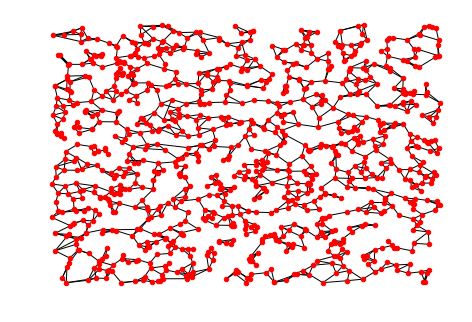

In [48]:
plot_g(G, with_labels=False, node_size=20, font_size=4)

In [66]:
from networkx import NetworkXNoPath

def calc_cosine_dist(p1, p2):
    return np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))

def encode_edges(G, parent, node, src, dst):
    
    ret = np.zeros((max_degree, 7))
    ret[:, -1] = -1
    
    x_dst = G.nodes[dst]['x']
    y_dst = G.nodes[dst]['y']
    x_src = G.nodes[src]['x']
    y_src = G.nodes[src]['y']
    
    for idx, edge in enumerate(G.edges(node)):
        u = edge[0]
        v = edge[1]
        
        # Only look forward
        # allow look backwards(shouldn't be included)
        if v == parent:
            continue
        
        ret[idx][0] = G.get_edge_data(u, v)['centrality']
        ret[idx][1] = G.get_edge_data(u, v)['weight']
        
        x_u = G.nodes[u]['x']
        y_u = G.nodes[u]['y']
        x_v = G.nodes[v]['x']
        y_v = G.nodes[v]['y']

        ret[idx][2] = calc_cosine_dist((x_v-x_u, y_v-y_u), (x_dst-x_u, y_dst-y_u))
        ret[idx][3] = calc_euclidean_dist(G, v, dst)
        ret[idx][4] = x_v
        ret[idx][5] = y_v
        ret[idx][-1] = v
        
    return (ret, x_src, y_src, x_dst, y_dst)

def generate_stochastic_dataset(G, sample_size_lower_bound=500, frequent=100):
    
    X = []
    y = []
    
    pair_path_dict = dict()
    
    selected_pairs = []
    sample_cnt = 0
    num_of_nodes = G.number_of_nodes()
    
    while True:
        src = np.random.randint(0, num_of_nodes)
        dst = np.random.randint(0, num_of_nodes)
        
        if src == dst:
            continue
        
        selected_pairs.append((src, dst))
        
        for src, dst in [(src, dst), (dst, src)]:
            try:
                path = nx.dijkstra_path(G, src, dst)
                # TODO record all paths for later use
                
            except NetworkXNoPath:
                print("No path between %d and %d" % (src, dst))
                break
            
            pair_path_dict[(src, dst)] = path
            
            parent_node = -1
            cur_node = src
            for mid_node in path[1:]:

#                 print('parent:(%d), X:(%d, %d), y:(%d)' % (parent_node, cur_node, dst, mid_node))
                X.append(encode_edges(G, parent_node, cur_node, src, dst))
                y.append(mid_node)
                
                parent_node = cur_node
                cur_node = mid_node
                
                sample_cnt += 1
                
                if sample_cnt % frequent == 0:
                    print("Collected %d samples." % (sample_cnt))
        
        if sample_cnt >= sample_size_lower_bound:
            break
        
    return X, y, selected_pairs, pair_path_dict

In [67]:
features, labels, selected_pairs, pair_path_dict = generate_stochastic_dataset(G, \
                                                               sample_size_lower_bound=250000, \
                                                               frequent=30000)
print("%d pairs are selected" % (len(selected_pairs)))

No path between 419 and 800
No path between 182 and 252
No path between 381 and 64
No path between 182 and 436
No path between 799 and 9
No path between 547 and 110
No path between 734 and 293
No path between 294 and 697
No path between 384 and 169
No path between 419 and 999
No path between 118 and 149
No path between 587 and 258
No path between 464 and 36
No path between 64 and 856
No path between 464 and 341
No path between 916 and 813
No path between 84 and 191
No path between 23 and 169
No path between 118 and 6
No path between 523 and 587
Collected 30000 samples.
No path between 822 and 9
No path between 424 and 613
No path between 464 and 116
No path between 975 and 586
No path between 587 and 961
No path between 64 and 732
No path between 289 and 633
No path between 256 and 512
No path between 379 and 35
No path between 633 and 964
No path between 118 and 573
No path between 935 and 569
No path between 169 and 602
No path between 257 and 43
No path between 169 and 896
No path b

In [68]:
print(len(labels))
print(len(selected_pairs))
print(len(pair_path_dict))

250006
4262
8144


In [69]:
pair_path_len_dict = map(lambda d: (d[0], len(d[1])), pair_path_dict.items())
max_selected_path_len = max(pair_path_len_dict, key=lambda d:d[1])
min_selected_path_len = min(pair_path_len_dict, key=lambda d:d[1])

print max_selected_path_len
print min_selected_path_len

((824, 594), 80)
((403, 394), 2)


In [70]:
def find_label_idx(feature, label):
    
    for idx, row in enumerate(feature):
        if label == row[-1]:
            break
    
    return idx

def augment_dataset(X, y, augmentation_index=20, print_freq=300000):
    
    sample_size = len(y)
    augmented_sample_size = augmentation_index * sample_size
    feature_size = 28
    
    X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)
    indices = np.arange(max_degree)
    
    cnt = 0
    for feature, label in zip(X, y):
        for _ in range(augmentation_index):
            np.random.shuffle(indices)
            
            feature_tmp = feature[0][indices]
            label_tmp = find_label_idx(feature_tmp, label)
            
            X_aug[cnt] = np.append(feature_tmp[:, :-1].reshape(-1), [feature[1], feature[2], feature[3], feature[4]])
            y_aug[cnt] = label_tmp
            
            cnt += 1
            
            if cnt % print_freq == 0:
                print("Processed %d samples" % (cnt))
            
    return X_aug, y_aug

In [71]:
X, y = augment_dataset(features, labels,\
                       augmentation_index=20, \
                       print_freq=600000)
print(X.shape)
print(y.shape)

Processed 600000 samples
Processed 1200000 samples
Processed 1800000 samples
Processed 2400000 samples
Processed 3000000 samples
Processed 3600000 samples
Processed 4200000 samples
Processed 4800000 samples
(5000120, 28)
(5000120,)


In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4000096, 28)
(4000096,)
(1000024, 28)
(1000024,)


In [73]:
batch_size = 128

train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_test, y_test, batch_size=batch_size)

In [74]:
def build_model(context=mx.gpu()):
    
    data = mx.sym.var('data')
    label = mx.sym.var('softmax_label')
    
    fc1  = mx.sym.FullyConnected(data=data, num_hidden=1024)
    fc1 = mx.sym.Activation(data=fc1, act_type="relu")
    
    fc2  = mx.sym.FullyConnected(data=fc1, num_hidden=512)
    fc2 = mx.sym.Activation(data=fc2, act_type="relu")
    
    fc3  = mx.sym.FullyConnected(data=fc2, num_hidden=max_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp, context=context)

In [75]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
model = build_model()
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params()

In [77]:
model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',  # use SGD to train
#               optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric='acc',  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 6000),
              epoch_end_callback = mx.callback.do_checkpoint("mymodel", 1),
              num_epoch=10) 

INFO:root:Epoch[0] Batch [6000]	Speed: 85943.45 samples/sec	accuracy=0.958675
INFO:root:Epoch[0] Batch [12000]	Speed: 100623.71 samples/sec	accuracy=0.958564
INFO:root:Epoch[0] Batch [18000]	Speed: 101404.40 samples/sec	accuracy=0.958594
INFO:root:Epoch[0] Batch [24000]	Speed: 94373.75 samples/sec	accuracy=0.958453
INFO:root:Epoch[0] Batch [30000]	Speed: 101724.15 samples/sec	accuracy=0.958663
INFO:root:Epoch[0] Train-accuracy=0.959156
INFO:root:Epoch[0] Time cost=41.566
INFO:root:Saved checkpoint to "mymodel-0001.params"
INFO:root:Epoch[0] Validation-accuracy=0.959662
INFO:root:Epoch[1] Batch [6000]	Speed: 95248.99 samples/sec	accuracy=0.958770
INFO:root:Epoch[1] Batch [12000]	Speed: 102926.42 samples/sec	accuracy=0.958487
INFO:root:Epoch[1] Batch [18000]	Speed: 99696.79 samples/sec	accuracy=0.958663
INFO:root:Epoch[1] Batch [24000]	Speed: 101506.48 samples/sec	accuracy=0.958695
INFO:root:Epoch[1] Batch [30000]	Speed: 100522.57 samples/sec	accuracy=0.958939
INFO:root:Epoch[1] Train-ac

In [78]:
# acc = mx.metric.Accuracy()
# train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size=batch_size)
# model.score(train_iter, acc)
# print('Acc on training set %f' % acc.get()[1])

# acc = mx.metric.Accuracy()
# test_iter = mx.io.NDArrayIter(X_test, y_test, batch_size=batch_size)
# model.score(test_iter, acc)
# print('Acc on test set %f' % acc.get()[1])

acc = mx.metric.Accuracy()
all_iter = mx.io.NDArrayIter(X, y, batch_size=batch_size)
model.score(all_iter, acc)
print('Acc on all %f' % acc.get()[1])

Acc on all 0.959815


In [79]:
def nn_infer_next_node(G, path, parent, cur_node, src, dst, model):
#     print("In nn_infer_next_node")
    input_vec, x_src, y_src, x_dst, y_dst = encode_edges(G, parent, cur_node, src, dst)
    
    real_input_vec = np.append(input_vec[:, :-1].reshape(-1), [x_src, y_src, x_dst, y_dst])
    pred = model.predict(mx.io.NDArrayIter(np.array([real_input_vec]), np.array([0]))).asnumpy()[0]
    pred_idx = np.argmax(pred)
    neighbor = int(input_vec[pred_idx][-1])
    
    if neighbor == -1:
#         print("Invalid prediction, randomizing next node")
        avaliable_neighbors = filter(lambda d: d >= 0, input_vec[:, -1])
        neighbor = int(avaliable_neighbors[np.random.randint(0, len(avaliable_neighbors))])
    
#     if neighbor in path:
#         print("Duplicated nodes, randomizing next node")
#         avaliable_neighbors = filter(lambda d: d >= 0 and d != neighbor, input_vec[:, -1])

#         if len(avaliable_neighbors) == 0:
#             print("Duplicated nodes, no other nodes available")
#         else:
#             neighbor = int(avaliable_neighbors[np.random.randint(0, len(avaliable_neighbors))])
        
    return (neighbor, G.get_edge_data(cur_node, neighbor)['weight'])

def dijkstra_path_finder(G, src, dst, model=None, invalid_path_threshold=100):
    
    path = [src]
    parent_node = -1
    cur_node = src
    total_weights = .0
    
    while True:
        
        if len(path) >= invalid_path_threshold:
            return path, total_weights, False
        
        next_node, weight = nn_infer_next_node(G, path, parent_node, cur_node, src, dst, model)
        total_weights += weight
        path.append(next_node)
        
        if next_node == dst:
            return path, total_weights, True
        
        parent_node = cur_node
        cur_node = next_node

In [111]:
# G = generate_low_degree_g()
def calc_statistics(G, pair_path_dict, num_to_test=100):
    found_cnt = 0
    opt_path_cnt = 0
    
    def calc_dot_dist(p1, p2):
        return np.dot(p1, p2)

    def calc_geo_dist(p1, p2):

        p_1 = np.array(p1)
        p_2 = np.array(p2)

        return np.sqrt(np.sum((p_1 - p_2)**2))

    def heuristic(node, dst):

        x_src = G.nodes[src]['x']
        y_src = G.nodes[src]['y']
        x_dst = G.nodes[dst]['x']
        y_dst = G.nodes[dst]['y']
        x_node = G.nodes[node]['x']
        y_node = G.nodes[node]['y']

        dist_src_2_dst = calc_geo_dist((x_src, y_src), (x_dst, y_dst))
        dot_src_2_node = calc_dot_dist((x_node-x_src, y_node-y_src), (x_dst-x_src, y_dst-y_src))
        ret = dist_src_2_dst - (dot_src_2_node) / dist_src_2_dst

        return ret
    
    pairs = pair_path_dict.keys()
    random.shuffle(pairs)
    
    for src, dst in pairs[:num_to_test]:

        nn_path, _, found = dijkstra_path_finder(G, src, dst, model=model, invalid_path_threshold=G.number_of_nodes())
        
        dijkstra_path = pair_path_dict[(src, dst)]
        
        if not found:
            
#             print("The model is unable to find a path between %d and %d" % (src, dst))
            
#             plot_dijkstra_nn_comparison(G, dijkstra_path, nn_path)
            
#             print("Dijkstra path :", dijkstra_path)
# #             print("NN path :", nn_path)
#             print('')
            continue

        found_cnt += 1
        
        if nn_path == dijkstra_path:
            opt_path_cnt = opt_path_cnt + 1

        else:
            print("The model is able to find a different path between %d and %d" % (src, dst))
            plot_dijkstra_nn_comparison(G, dijkstra_path, nn_path)
#             pass
# #             astar_path = nx.astar_path(G, src, dst, heuristic=heuristic)
#             print('Printing all paths for reference:')
            print("Dijkstra path :", dijkstra_path)
# #             print("A star path :", astar_path)
            print("NN path :", nn_path)
            print('')

    return found_cnt, opt_path_cnt

In [112]:
def print_paths_statistics(G, pair_path_dict, num_to_test=100):

    num_total_path = num_to_test

    found_cnt, opt_path_cnt = calc_statistics(G, pair_path_dict=pair_path_dict, num_to_test=num_to_test)
    print('%d out of %d can find path: %f' % (found_cnt, num_total_path, float(found_cnt)/num_total_path))
    print('%d out of %d can find optimal path: %f' % (opt_path_cnt, found_cnt, float(opt_path_cnt)/found_cnt))
    print('%d out of %d all paths can find optimal paths: %f' % (opt_path_cnt, num_total_path, float(opt_path_cnt)/num_total_path))

The model is able to find a different path between 839 and 749


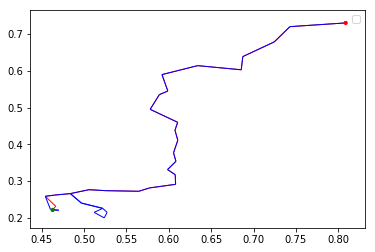

('Dijkstra path :', [839, 827, 983, 216, 930, 29, 311, 82, 694, 951, 259, 247, 635, 358, 698, 39, 598, 245, 708, 615, 826, 235, 566, 953, 888, 17, 749])
('NN path :', [839, 827, 983, 216, 930, 29, 311, 82, 694, 951, 259, 247, 635, 358, 698, 39, 598, 245, 708, 615, 826, 235, 566, 590, 550, 773, 600, 152, 550, 590, 566, 953, 888, 402, 45, 749])



The model is able to find a different path between 351 and 892


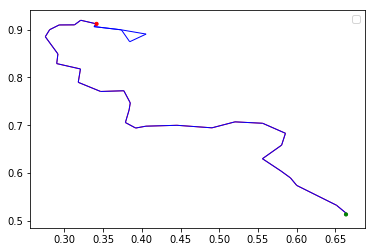

('Dijkstra path :', [351, 509, 44, 198, 256, 645, 242, 673, 368, 204, 316, 973, 357, 972, 625, 356, 908, 643, 812, 610, 709, 212, 86, 12, 505, 311, 88, 949, 771, 892])
('NN path :', [351, 955, 913, 133, 136, 913, 955, 351, 509, 44, 198, 256, 645, 242, 673, 368, 204, 316, 973, 357, 972, 625, 356, 908, 643, 812, 610, 709, 212, 86, 12, 505, 311, 88, 949, 771, 892])



The model is able to find a different path between 928 and 785


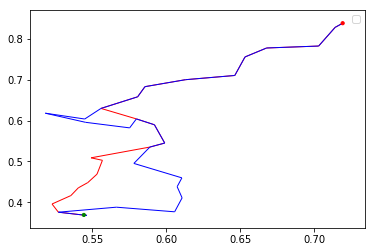

('Dijkstra path :', [928, 622, 104, 444, 735, 714, 273, 212, 86, 12, 505, 311, 82, 694, 582, 239, 120, 759, 74, 171, 360, 833, 83, 785])
('NN path :', [928, 622, 104, 444, 735, 714, 273, 212, 86, 12, 220, 456, 263, 736, 505, 311, 82, 694, 951, 259, 247, 635, 358, 832, 833, 83, 785])



The model is able to find a different path between 102 and 65


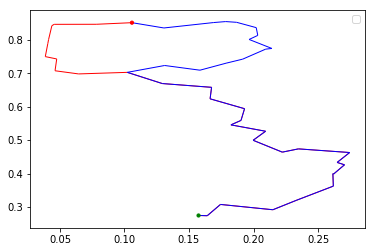

('Dijkstra path :', [102, 605, 798, 730, 187, 737, 251, 418, 484, 985, 581, 562, 725, 145, 110, 853, 675, 79, 496, 783, 209, 929, 47, 248, 417, 468, 116, 820, 57, 375, 203, 65])
('NN path :', [102, 395, 400, 131, 475, 416, 710, 747, 716, 225, 318, 821, 202, 164, 581, 562, 725, 145, 110, 853, 675, 79, 496, 783, 209, 929, 47, 248, 417, 468, 116, 820, 57, 375, 203, 65])



The model is able to find a different path between 550 and 179


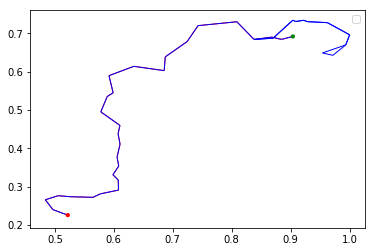

('Dijkstra path :', [550, 590, 566, 235, 826, 615, 708, 245, 598, 39, 698, 358, 635, 247, 259, 951, 694, 82, 311, 29, 930, 216, 983, 827, 839, 510, 345, 742, 179])
('NN path :', [550, 590, 566, 235, 826, 615, 708, 245, 598, 39, 698, 358, 635, 247, 259, 951, 694, 82, 311, 29, 930, 216, 983, 827, 839, 510, 678, 156, 141, 924, 294, 250, 219, 376, 994, 454, 376, 219, 250, 294, 924, 141, 156, 678, 510, 345, 742, 179])

Invalid prediction, randomizing next node
The model is able to find a different path between 117 and 206


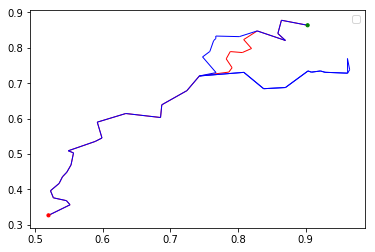

('Dijkstra path :', [117, 227, 83, 833, 360, 171, 74, 759, 120, 239, 582, 694, 82, 311, 29, 930, 216, 983, 827, 788, 531, 106, 346, 94, 681, 128, 542, 62, 721, 651, 206])
('NN path :', [117, 227, 83, 833, 360, 171, 74, 759, 120, 239, 582, 694, 82, 311, 29, 930, 216, 983, 827, 839, 510, 678, 156, 141, 924, 294, 250, 999, 791, 250, 294, 924, 141, 156, 678, 510, 839, 827, 796, 439, 810, 302, 274, 328, 282, 542, 62, 721, 651, 206])



Invalid prediction, randomizing next node
The model is able to find a different path between 854 and 409


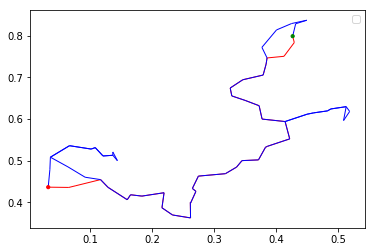

('Dijkstra path :', [854, 970, 552, 573, 71, 611, 252, 148, 522, 889, 363, 116, 468, 417, 248, 47, 929, 863, 745, 584, 10, 292, 261, 455, 489, 308, 897, 726, 731, 568, 680, 625, 972, 357, 137, 13, 409])
('NN path :', [854, 130, 927, 340, 594, 181, 119, 767, 950, 717, 767, 119, 181, 594, 340, 927, 934, 317, 573, 71, 611, 252, 148, 522, 889, 363, 116, 468, 417, 248, 47, 929, 863, 745, 584, 10, 292, 261, 455, 489, 185, 497, 488, 688, 723, 456, 286, 723, 688, 488, 497, 185, 489, 308, 897, 726, 731, 568, 680, 625, 972, 357, 973, 873, 8, 429, 262, 409])



The model is able to find a different path between 664 and 163


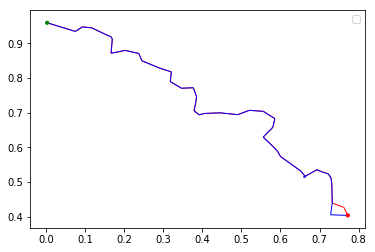

('Dijkstra path :', [664, 391, 904, 77, 123, 428, 213, 866, 423, 771, 949, 88, 311, 505, 12, 86, 212, 709, 610, 812, 643, 908, 356, 625, 972, 357, 973, 316, 204, 368, 673, 657, 987, 177, 161, 886, 852, 597, 304, 258, 313, 883, 603, 163])
('NN path :', [664, 641, 904, 77, 123, 428, 213, 866, 423, 771, 949, 88, 311, 505, 12, 86, 212, 709, 610, 812, 643, 908, 356, 625, 972, 357, 973, 316, 204, 368, 673, 657, 987, 177, 161, 886, 852, 597, 304, 258, 313, 883, 603, 163])

The model is able to find a different path between 724 and 968


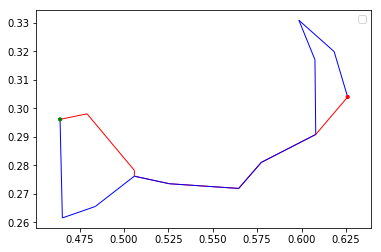

('Dijkstra path :', [724, 245, 708, 615, 826, 235, 893, 628, 968])
('NN path :', [724, 602, 39, 598, 245, 708, 615, 826, 235, 566, 953, 968])

The model is able to find a different path between 225 and 815


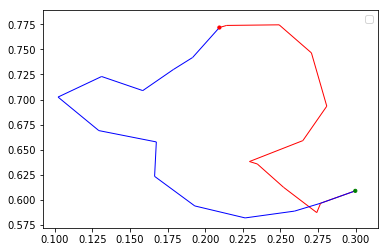

('Dijkstra path :', [225, 716, 918, 967, 823, 538, 223, 506, 960, 211, 670, 815])
('NN path :', [225, 318, 821, 202, 164, 581, 562, 725, 145, 110, 848, 149, 670, 815])



The model is able to find a different path between 994 and 502


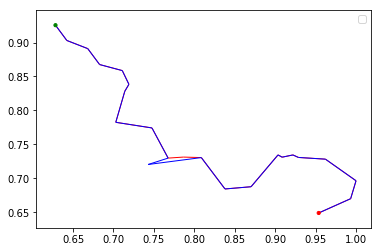

('Dijkstra path :', [994, 376, 219, 250, 294, 924, 141, 156, 678, 510, 839, 788, 796, 439, 104, 622, 928, 199, 860, 406, 350, 502])
('NN path :', [994, 376, 219, 250, 294, 924, 141, 156, 678, 510, 839, 827, 796, 439, 104, 622, 928, 199, 860, 406, 350, 502])



The model is able to find a different path between 440 and 256


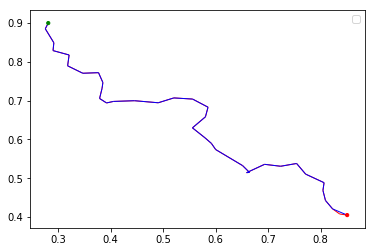

('Dijkstra path :', [440, 66, 463, 229, 338, 168, 100, 707, 922, 866, 423, 771, 949, 88, 311, 505, 12, 86, 212, 709, 610, 812, 643, 908, 356, 625, 972, 357, 973, 316, 204, 368, 673, 242, 645, 256])
('NN path :', [440, 463, 229, 338, 168, 100, 707, 922, 866, 423, 771, 949, 88, 311, 505, 12, 86, 212, 709, 610, 812, 643, 908, 356, 625, 972, 357, 973, 316, 204, 368, 673, 242, 645, 256])

The model is able to find a different path between 214 and 250


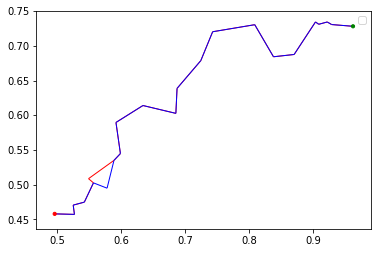

('Dijkstra path :', [214, 362, 529, 981, 239, 582, 694, 82, 311, 29, 930, 216, 983, 827, 839, 510, 678, 156, 141, 924, 294, 250])
('NN path :', [214, 362, 529, 981, 239, 951, 694, 82, 311, 29, 930, 216, 983, 827, 839, 510, 678, 156, 141, 924, 294, 250])

The model is able to find a different path between 903 and 552


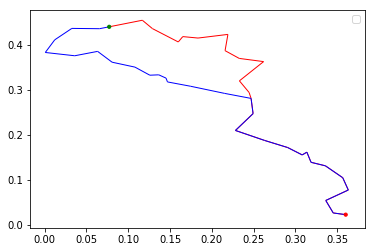

('Dijkstra path :', [903, 257, 249, 180, 958, 499, 4, 93, 655, 561, 567, 364, 577, 534, 647, 820, 116, 363, 889, 522, 148, 252, 611, 71, 573, 552])
('NN path :', [903, 257, 249, 180, 958, 499, 4, 93, 655, 561, 567, 364, 577, 534, 57, 375, 172, 52, 461, 76, 637, 623, 392, 589, 315, 802, 854, 970, 552])



The model is able to find a different path between 457 and 742


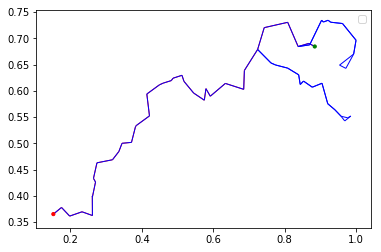

('Dijkstra path :', [457, 574, 572, 363, 116, 468, 417, 248, 47, 929, 863, 745, 584, 10, 292, 261, 455, 489, 185, 497, 488, 688, 723, 456, 263, 736, 505, 311, 29, 930, 216, 983, 827, 839, 510, 345, 742])
('NN path :', [457, 574, 572, 363, 116, 468, 417, 248, 47, 929, 863, 745, 584, 10, 292, 261, 455, 489, 185, 497, 488, 688, 723, 456, 263, 736, 505, 311, 29, 930, 216, 983, 323, 756, 105, 751, 125, 701, 777, 166, 856, 167, 160, 26, 474, 200, 809, 26, 160, 167, 856, 166, 777, 701, 125, 751, 105, 756, 323, 983, 827, 839, 510, 678, 156, 141, 924, 294, 250, 219, 376, 994, 454, 376, 219, 250, 294, 924, 141, 156, 678, 510, 345, 742])

Invalid prediction, randomizing next node


The model is able to find a different path between 189 and 215


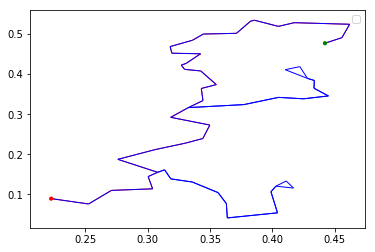

('Dijkstra path :', [189, 768, 592, 270, 81, 655, 920, 58, 108, 775, 797, 564, 138, 151, 121, 407, 23, 380, 498, 383, 16, 629, 863, 745, 584, 10, 292, 261, 705, 722, 408, 995, 215])
('NN path :', [189, 768, 592, 270, 81, 655, 93, 4, 499, 958, 180, 331, 284, 399, 154, 642, 297, 154, 399, 284, 331, 180, 958, 499, 4, 93, 655, 920, 58, 108, 775, 797, 564, 138, 703, 793, 55, 543, 458, 381, 844, 766, 533, 844, 381, 458, 543, 55, 793, 703, 138, 151, 121, 407, 23, 380, 498, 383, 16, 629, 863, 745, 584, 10, 292, 261, 705, 722, 408, 995, 215])



The model is able to find a different path between 80 and 63


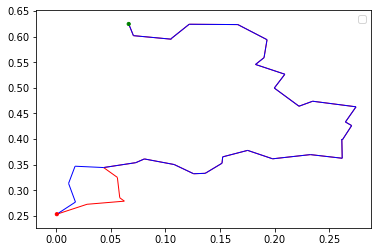

('Dijkstra path :', [80, 67, 85, 31, 672, 30, 662, 623, 637, 76, 461, 990, 457, 574, 572, 363, 116, 468, 417, 248, 47, 929, 209, 783, 496, 79, 675, 853, 110, 145, 704, 353, 246, 87, 63])
('NN path :', [80, 803, 674, 361, 30, 662, 623, 637, 76, 461, 990, 457, 574, 572, 363, 116, 468, 417, 248, 47, 929, 209, 783, 496, 79, 675, 853, 110, 145, 704, 353, 246, 87, 63])



The model is able to find a different path between 688 and 708


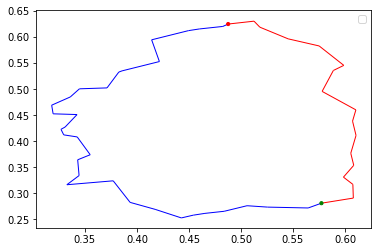

('Dijkstra path :', [688, 723, 456, 263, 736, 82, 694, 951, 259, 247, 635, 358, 698, 39, 598, 245, 708])
('NN path :', [688, 488, 497, 185, 489, 455, 261, 292, 10, 584, 745, 863, 629, 16, 383, 498, 380, 23, 407, 121, 151, 138, 703, 471, 882, 936, 888, 953, 566, 235, 826, 615, 708])



The model is able to find a different path between 364 and 144


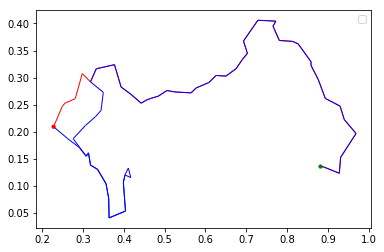

('Dijkstra path :', [364, 577, 877, 906, 916, 564, 138, 703, 471, 882, 936, 888, 953, 566, 235, 826, 615, 708, 245, 724, 536, 486, 394, 403, 636, 937, 641, 664, 111, 585, 780, 711, 479, 996, 352, 864, 253, 7, 816, 919, 516, 278, 144])
('NN path :', [364, 567, 561, 655, 93, 4, 499, 958, 180, 331, 284, 399, 154, 642, 297, 154, 399, 284, 331, 180, 958, 499, 4, 93, 655, 920, 58, 108, 775, 797, 564, 138, 703, 471, 882, 936, 888, 953, 566, 235, 826, 615, 708, 245, 724, 536, 486, 394, 403, 636, 937, 641, 664, 111, 585, 780, 711, 479, 996, 352, 864, 253, 7, 816, 919, 516, 278, 144])



The model is able to find a different path between 457 and 314


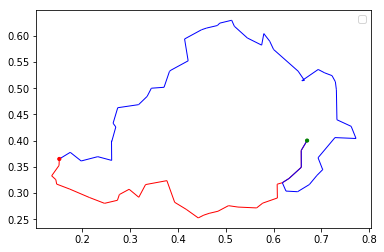

('Dijkstra path :', [457, 990, 461, 52, 172, 375, 57, 534, 236, 228, 916, 564, 138, 703, 471, 882, 936, 888, 953, 566, 235, 826, 615, 708, 245, 598, 602, 869, 127, 146, 96, 314])
('NN path :', [457, 574, 572, 363, 116, 468, 417, 248, 47, 929, 863, 745, 584, 10, 292, 261, 455, 489, 185, 497, 488, 688, 723, 456, 263, 736, 505, 311, 88, 949, 771, 423, 866, 213, 428, 123, 77, 904, 391, 664, 641, 937, 636, 403, 394, 486, 536, 724, 602, 869, 127, 146, 96, 314])



The model is able to find a different path between 740 and 46


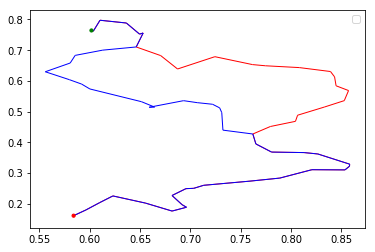

('Dijkstra path :', [740, 689, 905, 632, 595, 73, 876, 426, 288, 159, 1, 728, 374, 917, 255, 494, 996, 479, 711, 780, 585, 111, 391, 384, 338, 168, 515, 334, 372, 354, 125, 751, 105, 756, 323, 983, 216, 91, 714, 735, 389, 507, 676, 281, 46])
('NN path :', [740, 689, 905, 632, 595, 73, 876, 426, 288, 159, 1, 728, 374, 917, 255, 494, 996, 479, 711, 780, 585, 111, 391, 904, 77, 123, 428, 213, 866, 423, 771, 949, 88, 311, 505, 12, 86, 212, 273, 714, 735, 389, 507, 676, 281, 46])

The model is able to find a different path between 815 and 451


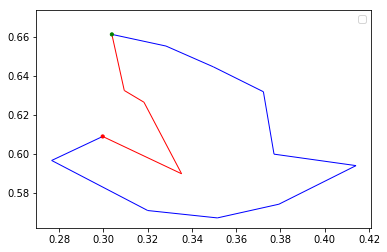

('Dijkstra path :', [815, 806, 817, 638, 451])
('NN path :', [815, 670, 596, 113, 112, 489, 308, 897, 726, 731, 451])

The model is able to find a different path between 658 and 420


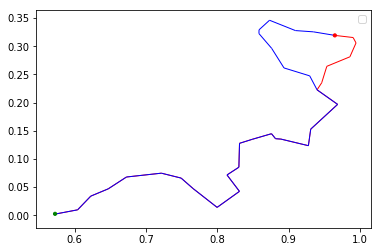

('Dijkstra path :', [658, 462, 413, 941, 840, 217, 7, 816, 919, 516, 278, 144, 275, 830, 289, 769, 359, 170, 421, 525, 312, 348, 59, 639, 691, 807, 68, 420])
('NN path :', [658, 478, 310, 696, 479, 996, 352, 864, 253, 7, 816, 919, 516, 278, 144, 275, 830, 289, 769, 359, 170, 421, 525, 312, 348, 59, 639, 691, 807, 68, 420])



The model is able to find a different path between 296 and 663


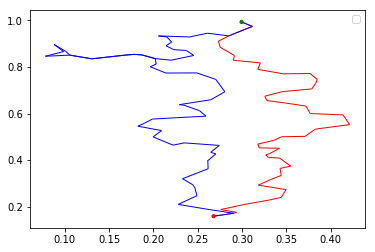

('Dijkstra path :', [296, 561, 472, 920, 58, 108, 775, 797, 564, 138, 151, 121, 407, 23, 380, 498, 383, 16, 629, 863, 745, 584, 10, 292, 261, 455, 489, 308, 897, 726, 731, 568, 680, 625, 972, 357, 973, 316, 204, 368, 673, 242, 645, 232, 287, 939, 107, 663])
('NN path :', [296, 561, 567, 364, 577, 534, 647, 820, 116, 468, 417, 248, 47, 929, 209, 783, 496, 79, 675, 853, 702, 848, 149, 960, 506, 223, 538, 823, 967, 918, 716, 747, 710, 416, 475, 131, 400, 395, 102, 605, 652, 51, 867, 102, 395, 400, 131, 475, 416, 343, 657, 987, 177, 992, 3, 811, 234, 306, 519, 734, 287, 939, 107, 663])



The model is able to find a different path between 576 and 828


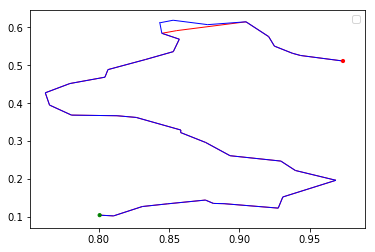

('Dijkstra path :', [576, 782, 943, 606, 167, 856, 965, 354, 372, 334, 515, 168, 338, 384, 391, 111, 585, 780, 711, 479, 996, 352, 864, 253, 7, 816, 919, 516, 278, 144, 275, 830, 289, 727, 828])
('NN path :', [576, 782, 943, 606, 167, 856, 166, 777, 701, 125, 354, 372, 334, 515, 168, 338, 384, 391, 111, 585, 780, 711, 479, 996, 352, 864, 253, 7, 816, 919, 516, 278, 144, 275, 830, 289, 727, 828])



The model is able to find a different path between 453 and 88


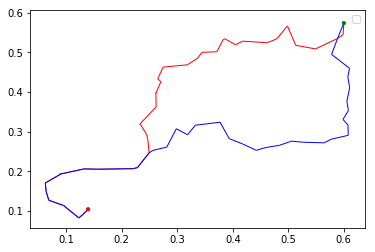

('Dijkstra path :', [453, 801, 424, 616, 41, 69, 554, 540, 36, 974, 976, 575, 364, 577, 534, 647, 820, 116, 468, 417, 248, 47, 929, 863, 745, 584, 10, 292, 261, 705, 722, 408, 895, 2, 964, 582, 694, 82, 88])
('NN path :', [453, 801, 424, 616, 41, 69, 554, 540, 36, 974, 976, 575, 364, 577, 877, 906, 916, 564, 138, 703, 471, 882, 936, 888, 953, 566, 235, 826, 615, 708, 245, 598, 39, 698, 358, 635, 247, 259, 951, 694, 88])

The model is able to find a different path between 972 and 17


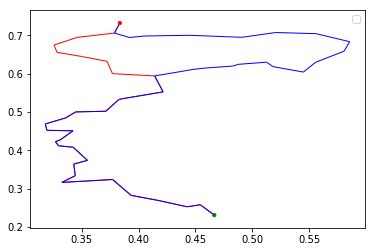

('Dijkstra path :', [972, 625, 680, 568, 731, 726, 897, 308, 489, 455, 261, 292, 10, 584, 745, 863, 629, 16, 383, 498, 380, 23, 407, 121, 151, 138, 703, 471, 882, 936, 888, 17])
('NN path :', [972, 625, 356, 908, 643, 812, 610, 709, 212, 86, 12, 220, 456, 723, 688, 488, 497, 185, 489, 455, 261, 292, 10, 584, 745, 863, 629, 16, 383, 498, 380, 23, 407, 121, 151, 138, 703, 471, 882, 936, 888, 17])

The model is able to find a different path between 734 and 806


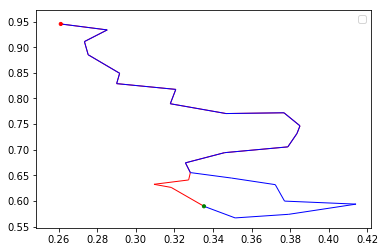

('Dijkstra path :', [734, 287, 232, 645, 242, 673, 368, 204, 316, 973, 357, 972, 625, 680, 568, 731, 980, 638, 817, 806])
('NN path :', [734, 287, 232, 645, 242, 673, 368, 204, 316, 973, 357, 972, 625, 680, 568, 731, 726, 897, 308, 489, 112, 113, 806])



The model is able to find a different path between 737 and 388


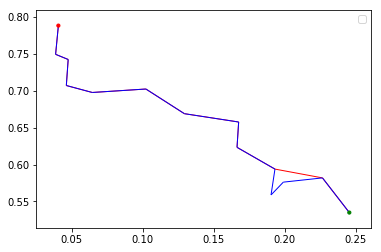

('Dijkstra path :', [737, 251, 418, 484, 985, 581, 562, 725, 145, 110, 848, 388])
('NN path :', [737, 251, 418, 484, 985, 581, 562, 725, 145, 110, 853, 702, 848, 388])



The model is able to find a different path between 544 and 786


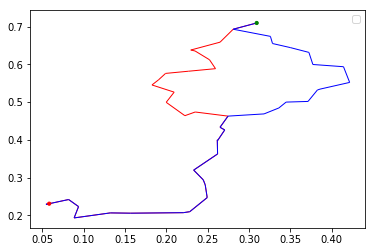

('Dijkstra path :', [544, 197, 501, 349, 36, 974, 976, 575, 364, 577, 534, 647, 820, 116, 468, 417, 248, 47, 929, 209, 783, 496, 79, 675, 853, 702, 848, 149, 960, 506, 223, 538, 823, 786])
('NN path :', [544, 197, 501, 349, 36, 974, 976, 575, 364, 577, 534, 647, 820, 116, 468, 417, 248, 47, 929, 863, 745, 584, 10, 292, 261, 455, 489, 308, 897, 726, 731, 568, 823, 786])

45 out of 50 can find path: 0.900000
15 out of 45 can find optimal path: 0.333333
15 out of 50 all paths can find optimal paths: 0.300000


In [113]:
print_paths_statistics(G, num_to_test=50, pair_path_dict=pair_path_dict)

# 9893 out of 9900 can find path: 0.999293
# 8803 out of 9893 can find optimal path: 0.889821
# 8803 out of 9900 all paths can find optimal paths: 0.889192

In [107]:
def plot_dijkstra_nn_comparison(G, dijkstra_node_list, nn_node_list):

    pos = {}

    for node in dijkstra_node_list:
        pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])

    dijkstra_edge_list = []
    for idx, node in enumerate(dijkstra_node_list[:-1]):
        dijkstra_edge_list.append((node, dijkstra_node_list[idx+1]))

    nx.draw_networkx_edges(G, pos=pos, edgelist=dijkstra_edge_list, node_size=20, edge_color='r')
    nn_pos = {}

    for node in nn_node_list:
        nn_pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])

    nn_edge_list = []
    for idx, node in enumerate(nn_node_list[:-1]):
        nn_edge_list.append((node, nn_node_list[idx+1]))

    nx.draw_networkx_edges(G, pos=nn_pos, edgelist=set(nn_edge_list), node_size=100, edge_color='b')
    
    nx.draw_networkx_nodes(G, pos=pos,\
                           nodelist=[dijkstra_node_list[0], dijkstra_node_list[-1]],\
                           node_size=10,\
                           node_color=['r', 'g'])
    
    plt.legend(loc='best')
    plt.show()

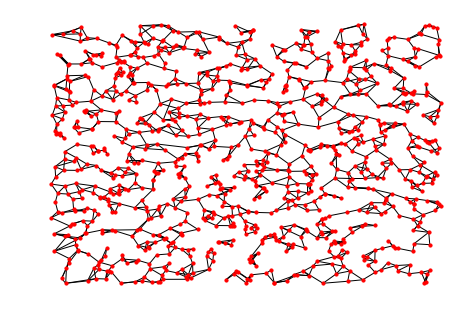

In [100]:
plot_g(G, with_labels=False, node_size=10, font_size=4)

# Some Analysis (TODO: draw more of those)

It seems that in the cases where the model fails to find a path, the model is trapped in a dead loop; however, at the early stage of inference, the generated path is not absolute
nonsense. At some point, the model makes a dubious turn and the paths are likely to diverge.